In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3

In [2]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn

db_h = create_connection('.\db\dat01')

optim_list = (
    "SGD",
    "Adam",
    "RMSprop",
)

hidden_units_list = (128, 256, 512, 1024, 2048)


In [3]:
# optimizers learn_rate vs hidin units
rpt_dml = """
SELECT
    learn_rate,
    sum(case when d.hidden_units = 128 then val_acc_step else 0 end) as acc_128,
    sum(case when d.hidden_units = 256 then val_acc_step else 0 end) as acc_256,
    sum(case when d.hidden_units = 512 then val_acc_step else 0 end) as acc_512,
    sum(case when d.hidden_units = 1024 then val_acc_step else 0 end) as acc_1024,
    sum(case when d.hidden_units = 2048 then val_acc_step else 0 end) as acc_2048,
    sum(case when d.hidden_units = 128 then val_loss else 0 end) as nll_128,
    sum(case when d.hidden_units = 256 then val_loss else 0 end) as nll_256,
    sum(case when d.hidden_units = 512 then val_loss else 0 end) as nll_512,
    sum(case when d.hidden_units = 1024 then val_loss else 0 end) as nll_1024,
    sum(case when d.hidden_units = 2048 then val_loss else 0 end) as nll_2048
from
    model_metric d
where
    1 = 1
    and d.val_loss != ''
    and d.epoch = 19
    and d.optimizers = '${optim}'
GROUP by 
    d.learn_rate
order by
    1 ASC
"""

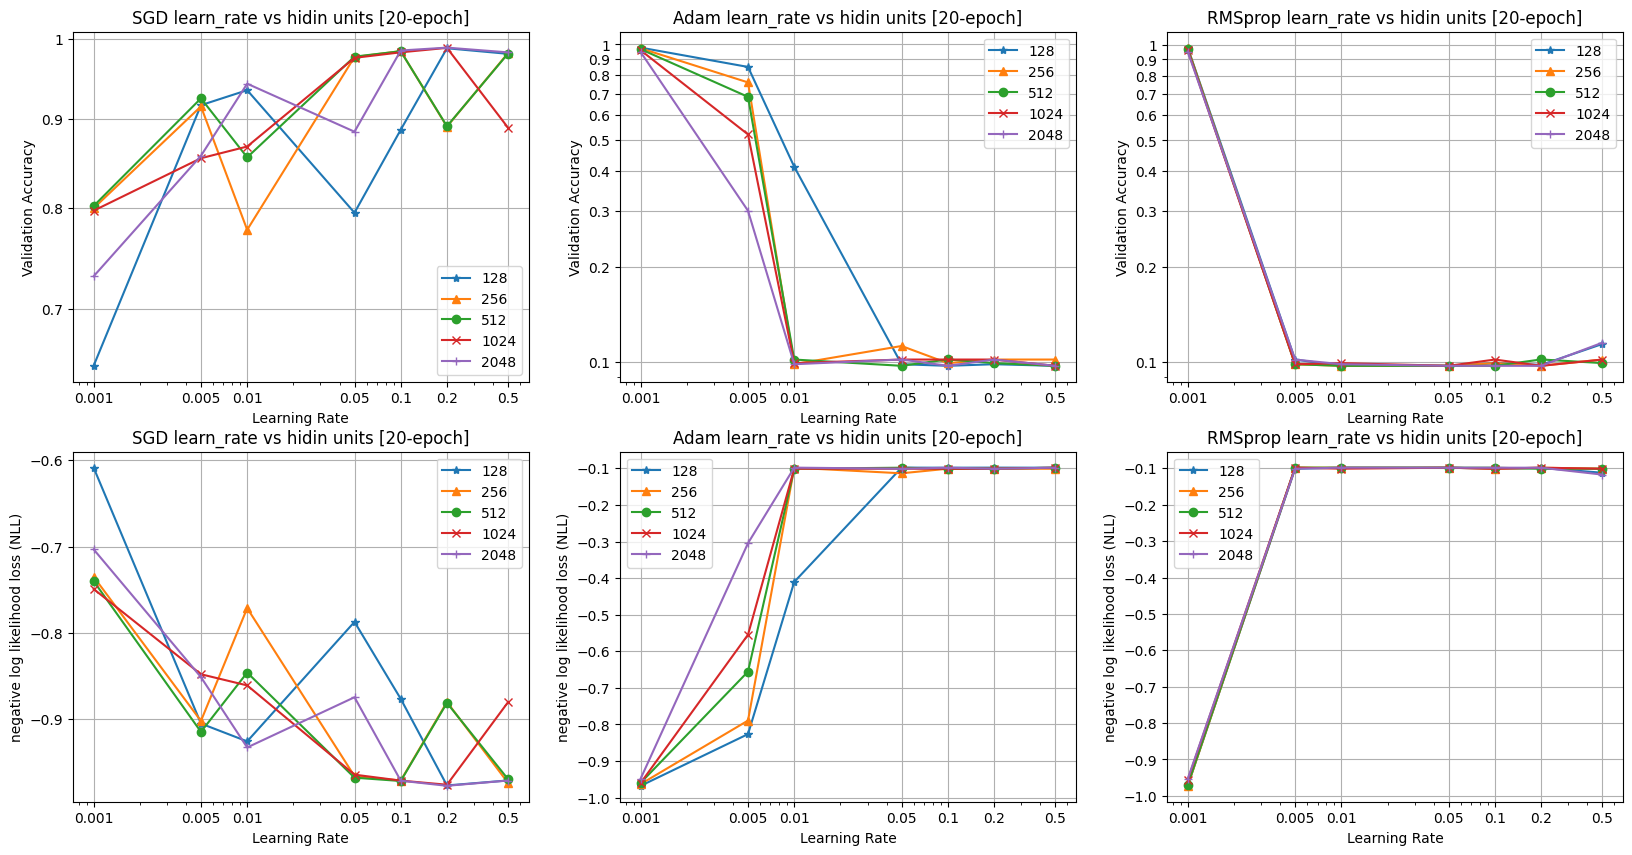

In [13]:
optim_list = ("SGD","Adam", "RMSprop", )

result = {}
fig = plt.figure(figsize=(20, 10))
# fig.tight_layout()
i = 0
acc_min = 0
acc_max = 0
for v_optim in optim_list:
    i += 1
    # print(rpt_dml.replace('${:optim}', v_optim))
    cur = db_h.execute(rpt_dml.replace("${optim}", v_optim))
    rows = cur.fetchall()

    result[v_optim] = {
        "learn_rate": [],
        "acc_128": [],
        "acc_256": [],
        "acc_512": [],
        "acc_1024": [],
        "acc_2048": [],
        "nll_128": [],
        "nll_256": [],
        "nll_512": [],
        "nll_1024": [],
        "nll_2048": [],
    }

    for row in rows:
        result[v_optim]["learn_rate"].append(row[0])
        result[v_optim]["acc_128"].append(row[1])
        result[v_optim]["acc_256"].append(row[2])
        result[v_optim]["acc_512"].append(row[3])
        result[v_optim]["acc_1024"].append(row[4])
        result[v_optim]["acc_2048"].append(row[5])
        result[v_optim]["nll_128"].append(row[6])
        result[v_optim]["nll_256"].append(row[7])
        result[v_optim]["nll_512"].append(row[8])
        result[v_optim]["nll_1024"].append(row[9])
        result[v_optim]["nll_2048"].append(row[10])

    ax = fig.add_subplot(2,3, i)
    ax.set_title(f"{v_optim} learn_rate vs hidin units [20-epoch]")
    ax.set_xlabel("Learning Rate")
    ax.set_ylabel("Validation Accuracy")
    ax.grid(True)
    ax.set_yscale("log", base=10)
    ax.set_xscale("log", base=10)
    ax.set_xticks([0.001 ,0.005 ,0.01 ,0.05 ,0.1 ,0.2 ,0.5],[0.001 ,0.005 ,0.01 ,0.05 ,0.1 ,0.2 ,0.5])
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    ax.plot(result[v_optim]["learn_rate"], result[v_optim]["acc_128"], "*-", label=128)
    ax.plot(result[v_optim]["learn_rate"], result[v_optim]["acc_256"], "^-", label=256)
    ax.plot(result[v_optim]["learn_rate"], result[v_optim]["acc_512"], "o-", label=512)
    ax.plot(result[v_optim]["learn_rate"], result[v_optim]["acc_1024"], "x-", label=1024)
    ax.plot(result[v_optim]["learn_rate"], result[v_optim]["acc_2048"], "+-", label=2048)
    ax.legend(loc="best")

    
    ax = fig.add_subplot(2,3, i+3)
    ax.set_title(f"{v_optim} learn_rate vs hidin units [20-epoch]")
    ax.set_xlabel("Learning Rate")
    ax.set_ylabel("negative log likelihood loss (NLL)")
    ax.grid(True)
    ax.set_xscale("log", base=10)
    # ax.set_yscale("log", base=10)
    ax.set_xticks([0.001 ,0.005 ,0.01 ,0.05 ,0.1 ,0.2 ,0.5],[0.001 ,0.005 ,0.01 ,0.05 ,0.1 ,0.2 ,0.5])
    ax.set_yticks([(t-10)/10 for t in range(0,11)])
    ax.plot(result[v_optim]["learn_rate"], result[v_optim]["nll_128"], "*-", label=128)
    ax.plot(result[v_optim]["learn_rate"], result[v_optim]["nll_256"], "^-", label=256)
    ax.plot(result[v_optim]["learn_rate"], result[v_optim]["nll_512"], "o-", label=512)
    ax.plot(result[v_optim]["learn_rate"], result[v_optim]["nll_1024"], "x-", label=1024)
    ax.plot(result[v_optim]["learn_rate"], result[v_optim]["nll_2048"], "+-", label=2048)
    ax.legend(loc="best")

In [10]:
# epoch vs learn_rate
rpt2_dml = """
SELECT
	d.epoch as epoch,
	max(case when d.learn_rate = 0.001 then val_acc_step else 0 end) as "acc_lr_0.001",
	max(case when d.learn_rate = 0.005 then val_acc_step else 0 end) as "acc_lr_0.005",
	max(case when d.learn_rate = 0.01 then val_acc_step else 0 end) as "acc_lr_0.01",
	max(case when d.learn_rate = 0.05 then val_acc_step else 0 end) as "acc_lr_0.05",
	max(case when d.learn_rate = 0.1 then val_acc_step else 0 end) as "acc_lr_0.1",
	max(case when d.learn_rate = 0.2 then val_acc_step else 0 end) as "acc_lr_0.2",
	max(case when d.learn_rate = 0.5 then val_acc_step else 0 end) as "acc_lr_0.5"
from
	model_metric d
where
	1 = 1
	and d.val_loss != ''
	and hidden_units = ${h_unit}
    and d.optimizers = '${optim}'
group by
	optimizers,
	d.epoch
order by
	1 asc,
	2 asc,
	3 asc
"""

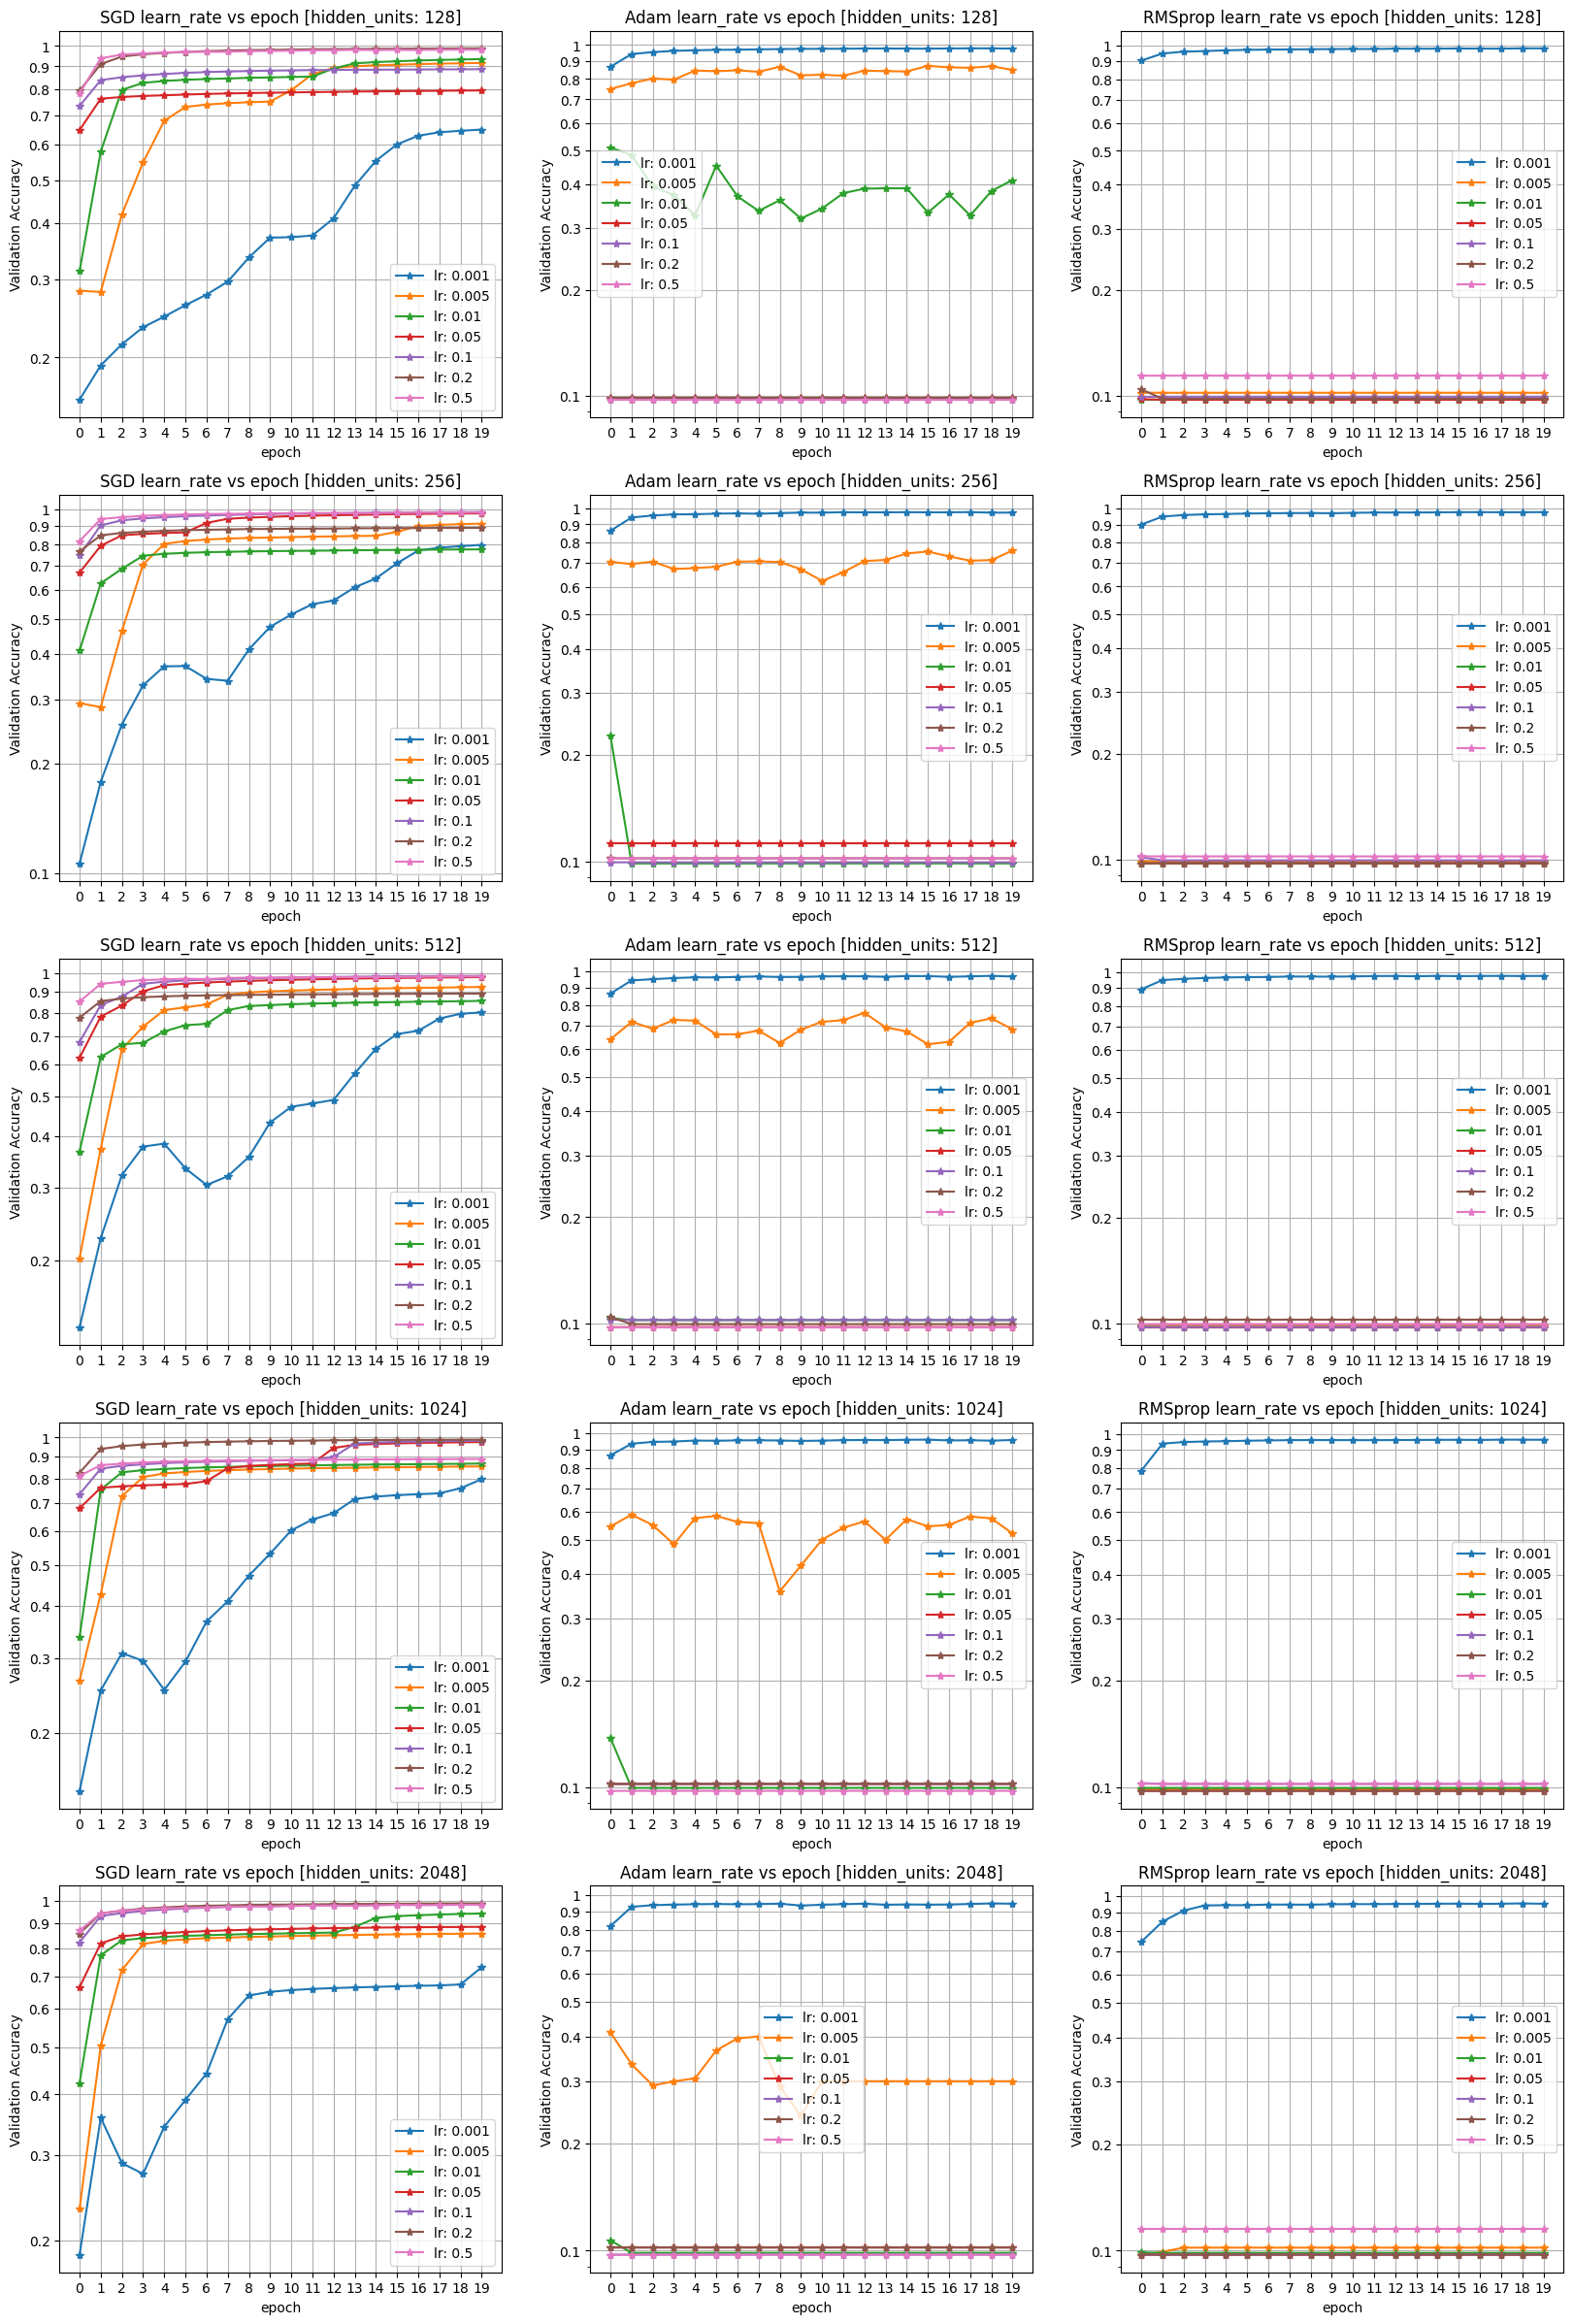

In [11]:
result = {}
fig2 = plt.figure(figsize=(20, 30))
fig2.tight_layout()
i = 0
acc_min = 0
acc_max = 0


for v_unit in hidden_units_list:
    for v_optim in optim_list:
        i += 1
        cur = db_h.execute(rpt2_dml.replace("${optim}", v_optim).replace('${h_unit}',str(v_unit)))
        rows = cur.fetchall()
        
        result[v_unit] = {}
        result[v_unit][v_optim] = {
            "epoch": [],
            "acc_lr_0.001": [],
            "acc_lr_0.005": [],
            "acc_lr_0.01": [],
            "acc_lr_0.05": [],
            "acc_lr_0.1": [],
            "acc_lr_0.2": [],
            "acc_lr_0.5": [],
        }

        for row in rows:
            result[v_unit][v_optim]["epoch"].append(row[0])
            result[v_unit][v_optim]["acc_lr_0.001"].append(row[1])
            result[v_unit][v_optim]["acc_lr_0.005"].append(row[2])
            result[v_unit][v_optim]["acc_lr_0.01"].append(row[3])
            result[v_unit][v_optim]["acc_lr_0.05"].append(row[4])
            result[v_unit][v_optim]["acc_lr_0.1"].append(row[5])
            result[v_unit][v_optim]["acc_lr_0.2"].append(row[6])
            result[v_unit][v_optim]["acc_lr_0.5"].append(row[7])


        ax = fig2.add_subplot(5, 3, i)
        ax.set_title(f"{v_optim} learn_rate vs epoch [hidden_units: {v_unit}]")
        ax.set_xlabel("epoch")
        ax.set_ylabel("Validation Accuracy")
        ax.grid(True)
        ax.set_yscale("log", base=10)
        # ax.set_xscale("log", base=10)
        ax.set_xticks([i for i in range(20)])
        ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
        ax.plot(result[v_unit][v_optim]["epoch"], result[v_unit][v_optim]["acc_lr_0.001"], "*-", label='lr: 0.001')
        ax.plot(result[v_unit][v_optim]["epoch"], result[v_unit][v_optim]["acc_lr_0.005"], "*-", label='lr: 0.005')
        ax.plot(result[v_unit][v_optim]["epoch"], result[v_unit][v_optim]["acc_lr_0.01"], "*-", label='lr: 0.01')
        ax.plot(result[v_unit][v_optim]["epoch"], result[v_unit][v_optim]["acc_lr_0.05"], "*-", label='lr: 0.05')
        ax.plot(result[v_unit][v_optim]["epoch"], result[v_unit][v_optim]["acc_lr_0.1"], "*-", label='lr: 0.1')
        ax.plot(result[v_unit][v_optim]["epoch"], result[v_unit][v_optim]["acc_lr_0.2"], "*-", label='lr: 0.2')
        ax.plot(result[v_unit][v_optim]["epoch"], result[v_unit][v_optim]["acc_lr_0.5"], "*-", label='lr: 0.5')
        ax.legend(loc="best")